<a href="https://colab.research.google.com/github/Cairo-Henrique/BQC-Quantum-Tech/blob/main/Bloco_1/BQC_Aula_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brazil Quantum Camp

**Aula 8**: Introdução a Algoritmos Quânticos

In [ ]:
!pip install qiskit qiskit-aer pylatexenc qiskit-ibm-runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.4 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=cb41a704cb5f63e8355077fc7a4d15153795184e31eff70c8318337f6b5e060a
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178

# **Circuito de Teletransporte**

Circuito de teletransporte para enviar a mensagem encodada no estado $|Ψ⟩=α|0⟩+β|1⟩$.

Estado Enviado: 0.71|0> + 0.00+0.71j|1>


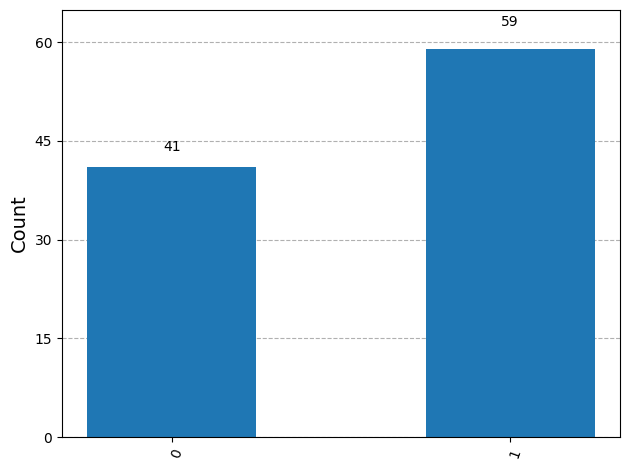

In [ ]:
# ======================================================
# 1. CIRCUITO
# ======================================================
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
# Define os registros
reg_m = QuantumRegister(1, name="M")
reg_a = QuantumRegister(1, name="A")
reg_b = QuantumRegister(1, name="B")
cr_alice = ClassicalRegister(2, name="alice")
cr_bob   = ClassicalRegister(1, name="bob")

# Define o circuito quântico
qc = QuantumCircuit(reg_m, reg_a, reg_b, cr_alice, cr_bob)

import numpy as np
# 1.1) Constroi a mensagem e o par emaranhado
alpha = 1j/np.sqrt(2)  # Admite valores complexos
beta  = np.sqrt(1 - np.abs(alpha)**2)
vetor_estado = [beta, alpha]
qc.initialize(vetor_estado, reg_m[0])

# 1.2) Emaranhamento
qc.h(reg_a[0])
qc.cx(reg_a[0], reg_b[0])
qc.barrier()

# 2.1) Circuito de Bell inverso
qc.cx(reg_m[0], reg_a[0])
qc.h(reg_m[0])
qc.barrier()
# 2.2) Medição da Alice
qc.measure(reg_m[0], cr_alice[0])
qc.measure(reg_a[0], cr_alice[1])
qc.barrier()

# 3) Correções feitas por Bob
with qc.if_test((cr_alice[1], 1)):
    qc.x(reg_b[0])
with qc.if_test((cr_alice[0], 1)):
    qc.z(reg_b[0])
qc.barrier()

# 4) Medição de Bob
qc.measure(reg_b[0], cr_bob[0])

# Opcional) Mostrar o circuito
#display(qc.draw('mpl'))


# ======================================================
# 2. EXECUÇÃO
# ======================================================
from qiskit_aer import AerSimulator
from qiskit import generate_preset_pass_manager
from qiskit_ibm_runtime import Sampler
from qiskit.visualization import plot_histogram

backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend)
isa_qc = pm.run(qc)
sampler = Sampler(backend)
job = sampler.run([isa_qc], shots=100)
result = job.result()
counts_bob = result[0].data.bob.get_counts()
plot_histogram(counts_bob)

# Prints auxiliares
print(f"Estado Enviado: {beta:.2f}|0> + {alpha:.2f}|1>")
display(plot_histogram(counts_bob))

# **Algoritmo de Deutsch**
Algoritmo generalizado para resolver o problema de Deutsch.

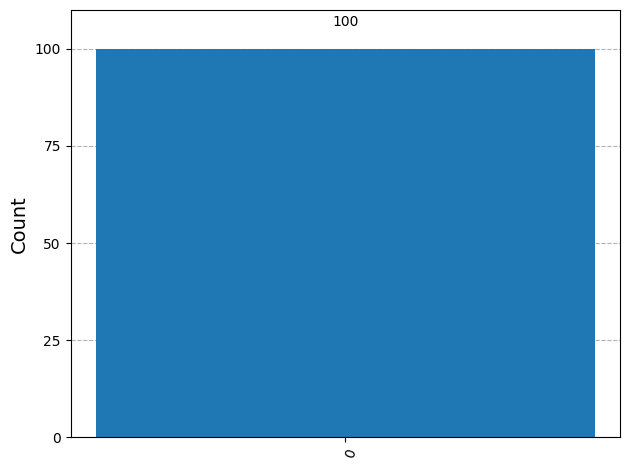

In [ ]:
# ==========================================================
# 1. ORÁCULO
# ==========================================================
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
oracle_qc = QuantumCircuit(2, name="O")
# Define o oráculo por portas lógicas
# PORTAS AQUI
oracle_gate = oracle_qc.to_gate()

# ==========================================================
# 2. ALGORITMO
# ==========================================================
# Define os registros quânticos
qr = QuantumRegister(1, 'q')      # Dados
aux = QuantumRegister(1, 'aux')   # Auxiliar
# Define o registro clássico
cr = ClassicalRegister(1, 'c')
# Define o circuito quântico
qc = QuantumCircuit(qr, aux, cr)

# 1) Prepara o qubit auxiliar
qc.x(aux)
qc.h(aux)
qc.barrier()

# 2) Aplica a Hadamard
qc.h(qr)
qc.barrier()

# 3) Aplica o Oráculo
qc.append(oracle_gate, list(qr) + list(aux))

# 4) Aplica a Hadamard
qc.h(qr)
qc.barrier()

# Final) Medição
qc.measure(qr, cr)

# Opcional) Mostrar o circuito
#display(qc.draw('mpl'))
# Mostra o circuito com o oraculo exposto
#display(qc.decompose().draw('mpl'))

# ==========================================================
# 3. EXECUÇÃO
# ==========================================================
from qiskit_aer import AerSimulator
from qiskit import generate_preset_pass_manager
from qiskit_ibm_runtime import Sampler
from qiskit.visualization import plot_histogram

backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend)
isa_qc = pm.run(qc)
sampler = Sampler(backend)
job = sampler.run([isa_qc], shots=100)
result = job.result()
counts = result[0].data.c.get_counts()
plot_histogram(counts)


# **Algoritmo de Deutsch-Josza**
Algoritmo generalizado para resolver o problema de Deutsch-Josza.


In [ ]:
# ==========================================================
# 1. ORÁCULO
# ==========================================================
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
n =   # Número de qubits de dados
oracle_qc = QuantumCircuit(n + 1, name="O")
# Define o oráculo por portas lógicas
# PORTAS AQUI
oracle_gate = oracle_qc.to_gate()

# ==========================================================
# 2. ALGORITMO
# ==========================================================
# Define os registros quânticos
qr = QuantumRegister(n, 'q')      # Dados
aux = QuantumRegister(1, 'aux')   # Auxiliar
# Define o registro clássico
cr = ClassicalRegister(n, 'c')
# Define o circuito quântico
qc = QuantumCircuit(qr, aux, cr)

# 1) Prepara o qubit auxiliar
qc.x(aux)
qc.h(aux)
qc.barrier()

# 2) Aplica a Hadamard
qc.h(qr)
qc.barrier()

# 3) Aplica o Oráculo
qc.append(oracle_gate, list(qr) + list(aux))

# 4) Aplica a Hadamard
qc.h(qr)
qc.barrier()

# Final) Medição
qc.measure(qr, cr)

# Opcional) Mostrar o circuito
#display(qc.draw('mpl'))
# Mostra o circuito com o oraculo exposto
#display(qc.decompose().draw('mpl'))

# ==========================================================
# 3. EXECUÇÃO
# ==========================================================
from qiskit_aer import AerSimulator
from qiskit import generate_preset_pass_manager
from qiskit_ibm_runtime import Sampler
from qiskit.visualization import plot_histogram

backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend)
isa_qc = pm.run(qc)
sampler = Sampler(backend)
job = sampler.run([isa_qc], shots=100)
result = job.result()
counts = result[0].data.c.get_counts()
plot_histogram(counts)


SyntaxError: invalid syntax (ipython-input-3895979511.py, line 5)

# **Algoritmo de Bernstein-Vazirani**

Algoritmo generalizado para resolver o problema de Bernstein-Vazirani.


In [ ]:
# ==========================================================
# 1. ORÁCULO
# ==========================================================
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
n =  # Número de qubits de dados
oracle_qc = QuantumCircuit(n + 1, name="O")
# Define o oráculo por portas lógicas
# PORTAS AQUI
oracle_gate = oracle_qc.to_gate()

# ==========================================================
# 2. ALGORITMO
# ==========================================================
# Define os registros quânticos
qr = QuantumRegister(n, 'q')      # Dados
aux = QuantumRegister(1, 'aux')   # Auxiliar
# Define o registro clássico
cr = ClassicalRegister(n, 'c')

# Define o circuito quântico
qc = QuantumCircuit(qr, aux, cr)

# 1) Prepara o qubit auxiliar
qc.x(aux)
qc.h(aux)
qc.barrier()

# 2) Aplica a Hadamard
qc.h(qr)
qc.barrier()

# 3) Aplica o Oráculo
qc.append(oracle_gate, list(qr) + list(aux))

# 4) Aplica a Hadamard
qc.h(qr)
qc.barrier()

# Final) Medição
qc.measure(qr, cr)

# Opcional) Mostrar o circuito
#display(qc.draw('mpl'))
# Mostra o circuito com o oraculo exposto
#display(qc.decompose().draw('mpl'))

# ==========================================================
# 3. EXECUÇÃO
# ==========================================================
from qiskit_aer import AerSimulator
from qiskit import generate_preset_pass_manager
from qiskit_ibm_runtime import Sampler
from qiskit.visualization import plot_histogram

backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend)
isa_qc = pm.run(qc)
sampler = Sampler(backend)
job = sampler.run([isa_qc], shots=100)
result = job.result()
counts = result[0].data.c.get_counts()
plot_histogram(counts)


# **Exercício 4: Implementação do Oráculo**

A função booleana $f:\{0,1\}^{4}→\{0,1\}$ esta definida pelo oráculo abaixo. Implemente o oráculo no algoritmo de Deutsch-Josza e determine se a função é constante ou  balanceda.
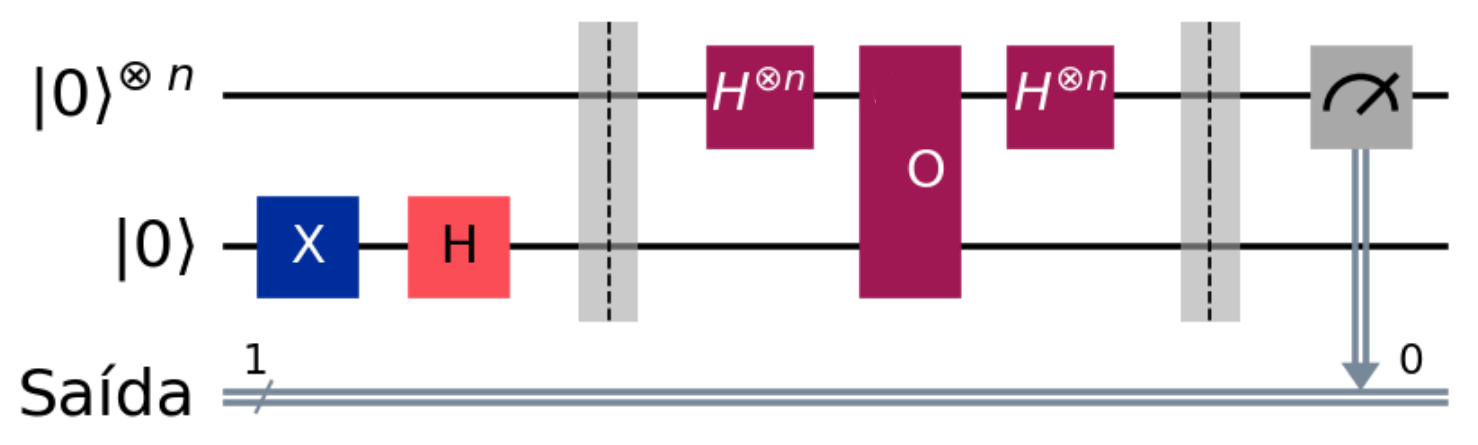


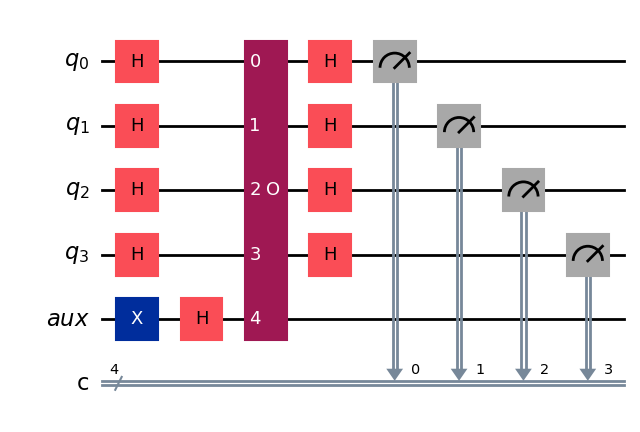

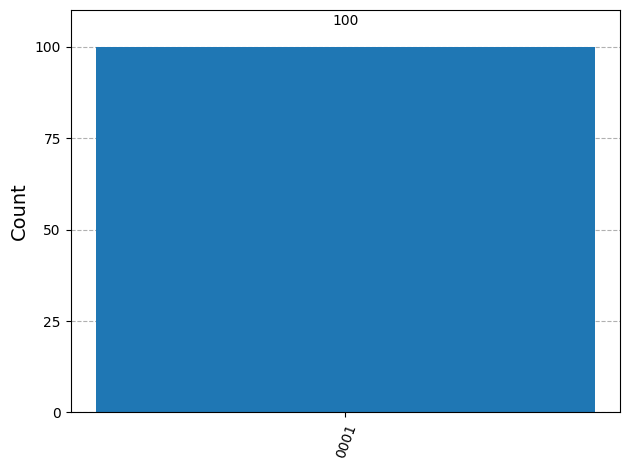

In [ ]:
# Oraculo a ser implementado no Algoritimo de DJ
# ==========================================================
# 1. ORÁCULO
# ==========================================================
n = 4
oracle_qc = QuantumCircuit(n+1, name="O")
oracle_qc.cx(0, 4)
oracle_gate = oracle_qc.to_gate()

qr = QuantumRegister(n, 'q')      # Dados
aux = QuantumRegister(1, 'aux')   # Auxiliar
cr = ClassicalRegister(n, 'c')

# Define o circuito quântico
qc = QuantumCircuit(qr, aux, cr)

qc.x(aux)
qc.h(aux)
qc.h(qr)

# 3) Aplica o Oráculo
qc.append(oracle_gate, list(qr) + list(aux))

qc.h(qr)

# Final) Medição
qc.measure(qr, cr)

# Opcional) Mostrar o circuito
display(qc.draw('mpl'))
# Mostra o circuito com o oraculo exposto
#display(qc.decompose().draw('mpl'))

backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend)
isa_qc = pm.run(qc)
sampler = Sampler(backend)
job = sampler.run([isa_qc], shots=100)
result = job.result()
counts = result[0].data.c.get_counts()
plot_histogram(counts)

# **Exercício 5: Implementação do Oráculo**

A função booleana $f:\{0,1\}^{4}→\{0,1\}$ esta definida pelo oráculo abaixo. Implemente o oráculo no algoritmo de Bernstein-Vazirani e determine a chave secreta.
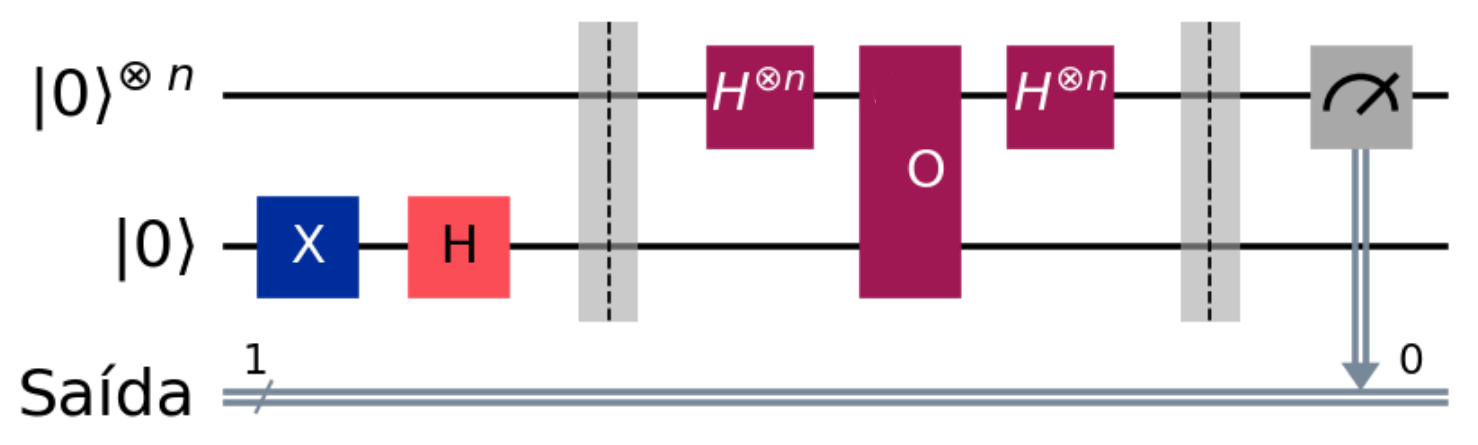

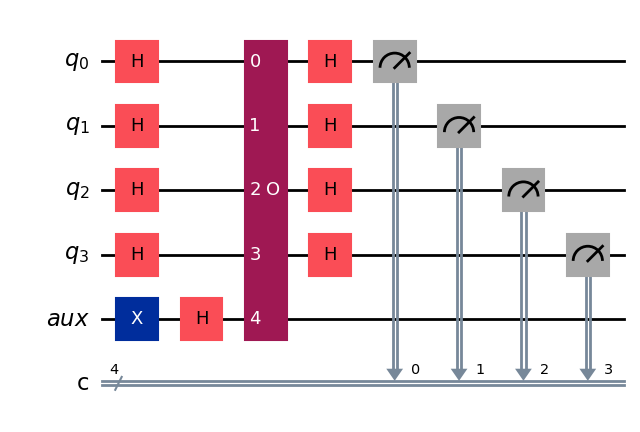

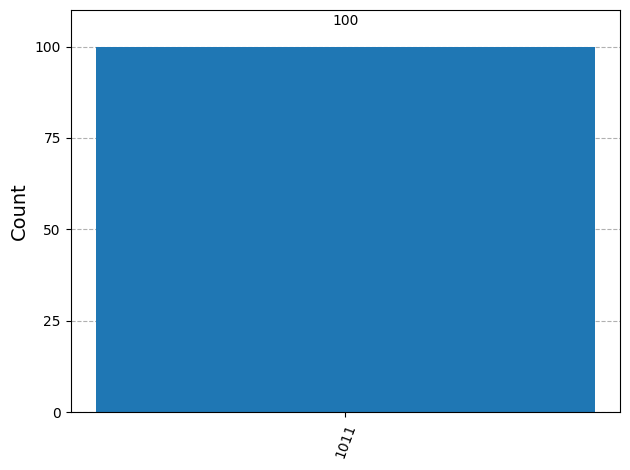

In [ ]:
# Oraculo a ser implementado no Algoritimo de BV (s=1101)
# ==========================================================
# 1. ORÁCULO
# ==========================================================
n= 4 # Número de qubits de dados
oracle_qc = QuantumCircuit(n+1, name="O")
oracle_qc.cx(0, 4)
oracle_qc.cx(1, 4)
oracle_qc.cx(3, 4)
oracle_gate = oracle_qc.to_gate()

qr = QuantumRegister(n, 'q')      # Dados
aux = QuantumRegister(1, 'aux')   # Auxiliar
cr = ClassicalRegister(n, 'c')

# Define o circuito quântico
qc = QuantumCircuit(qr, aux, cr)

qc.x(aux)
qc.h(aux)

qc.h(qr)

# 3) Aplica o Oráculo
qc.append(oracle_gate, list(qr) + list(aux))

qc.h(qr)

# Final) Medição
qc.measure(qr, cr)

# Opcional) Mostrar o circuito
display(qc.draw('mpl'))
# Mostra o circuito com o oraculo exposto
#display(qc.decompose().draw('mpl'))

backend = AerSimulator()
pm = generate_preset_pass_manager(backend=backend)
isa_qc = pm.run(qc)
sampler = Sampler(backend)
job = sampler.run([isa_qc], shots=100)
result = job.result()
counts = result[0].data.c.get_counts()
plot_histogram(counts)